In [ ]:
import requests, json
import hashlib
import datetime
import pandas as pd 
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, ArrayType, DateType, TimestampType
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, from_unixtime, unix_timestamp, to_date
from datetime import timedelta, date
from delta.tables import DeltaTable

### Set the constants for the silver layer job

In [ ]:
const_timestamp = datetime.datetime.today().replace(second=0, microsecond=0)

currency_api_url = r"https://v6.exchangerate-api.com/v6/479d2c7b7ab257e9cdf338e5/latest/USD"

currency_api_schema = StructType([StructField("currency_name", StringType(), True)\
                     ,StructField("currency_value", FloatType(), True)])

log_file_list = [
    "https://raw.githubusercontent.com/PacktPublishing/Data-Engineering-with-Apache-Spark-Delta-Lake-and-Lakehouse/main/project/prep/ecommerce_logs/electroniz_access_log_1.log",
    "https://raw.githubusercontent.com/PacktPublishing/Data-Engineering-with-Apache-Spark-Delta-Lake-and-Lakehouse/main/project/prep/ecommerce_logs/electroniz_access_log_2.log"
    ]

# Gather the following details from your Kusto database and replace the values below.
kusto_database = "ecommerce_sales"
kusto_table = "bronze_ecommerce_orders"
kusto_uri = "https://trd-m2z6s8hhrg1xkyf1yn.z9.kusto.fabric.microsoft.com"

### Create the silver delta tables using SQL statements

In [ ]:
%%sql
CREATE TABLE IF NOT EXISTS silver_store_customers 
(customer_id Integer,
    customer_name String,
    address String,
    city String,
    postalcode String,
    country String,
    phone String,
    email String,
    credit_card String,
    updated_at Timestamp);

CREATE TABLE IF NOT EXISTS silver_store_orders
(order_number Integer,
    customer_id Integer,
    product_id Integer,
    order_date Date,
    units Integer,
    sale_price Float,
    currency String,
    order_mode String,
    sale_price_usd Float,
    updated_at Timestamp);

CREATE TABLE IF NOT EXISTS silver_products
(product_id Integer,
    product_name String,
    product_category String,
    updated_at Timestamp);

CREATE TABLE IF NOT EXISTS silver_currency
(currency_value Float,
    currency_name String,
    updated_at Timestamp);

CREATE TABLE IF NOT EXISTS silver_geolocation
(ip1 Integer,
    ip2 Integer,
    country_code String,
    country_name String,
    updated_at Timestamp);

### Create the  delta tables using Pyspark API

In [ ]:
#Create inventory silver Table
DeltaTable.createIfNotExists(spark) \
    .tableName('silver_inventory') \
    .addColumn('inventory_date', 'Timestamp') \
    .addColumn('product', 'String') \
    .addColumn('inventory', 'Integer') \
    .addColumn('updated_at', 'Timestamp') \
	.execute()
    
#Create LOGS silver Table
DeltaTable.createIfNotExists(spark) \
    .tableName('silver_logs') \
    .addColumn('time', 'String') \
    .addColumn('remote_ip', 'String') \
    .addColumn('country_name', 'String') \
    .addColumn('ip_number', 'Integer') \
    .addColumn('request', 'String') \
    .addColumn('response', 'String') \
    .addColumn('agent', 'String') \
    .addColumn('updated_at', 'Timestamp') \
	.execute()


#Create ECOMM silver Table
DeltaTable.createIfNotExists(spark) \
    .tableName('silver_ecommerce_orders') \
    .addColumn('customer_name', 'String') \
    .addColumn('address', 'String') \
    .addColumn('city', 'String') \
    .addColumn('country', 'String') \
    .addColumn('currency', 'String') \
    .addColumn('email', 'String') \
    .addColumn('order_date', 'Date') \
    .addColumn('order_mode', 'String') \
    .addColumn('order_number', 'Integer') \
    .addColumn('phone', 'String') \
    .addColumn('postalcode', 'String') \
    .addColumn('product_name', 'String') \
    .addColumn('sale_price', 'Float') \
    .addColumn('sale_price_usd', 'Float') \
    .addColumn('updated_at', 'Timestamp') \
	.execute()

### Register the PySpark UDFs
### UDF’s are used to extend the functions of the framework and re-use them in multiple DataFrames.

In [ ]:
def mask_value(col):
  column = str(col)
  mask_value = hashlib.sha256(column.encode()).hexdigest()
  return mask_value

def curate_email(email):
  curated_value = email.lower()
  return curated_value

def curate_country(country):
  if (country == 'USA' or country == 'United States'):
    curated_value = 'USA'
  elif (country == 'UK' or country == 'United Kingdom'):
    curated_value = 'UK'
  elif (country == 'CAN' or country == 'Canada'):
    curated_value = 'CAN'
  elif (country == 'IND' or country == 'India'):
    curated_value = 'IND'
  else:
    curated_value = country
  return curated_value

def curate_sales_price(currency, currency_value, sales_price):
  if (currency != 'USD'):
    curated_value = float(sales_price)/float(currency_value)
    return float(curated_value)
  else:
    return float(sales_price)

def ip_to_country(ip):
  ipsplit = ip.split(".")
  ip_number=16777216*int(ipsplit[0]) + 65536*int(ipsplit[1]) + 256*int(ipsplit[2]) + int(ipsplit[3])  
  return ip_number

def read_api(url: str):
    normalized_data = dict()
    data = requests.get(currency_api_url).json() 
    normalized_data["_data"] = data 
    return json.dumps(normalized_data)

mask_udf = udf(mask_value, StringType())
curate_email_udf = udf(curate_email, StringType())
curate_country_udf = udf(curate_country, StringType())
curate_sales_price_udf = udf(curate_sales_price, FloatType())
ip_to_country_udf = udf(ip_to_country, StringType())

# Implement Data Quality Rule 1 - Mask PII Data
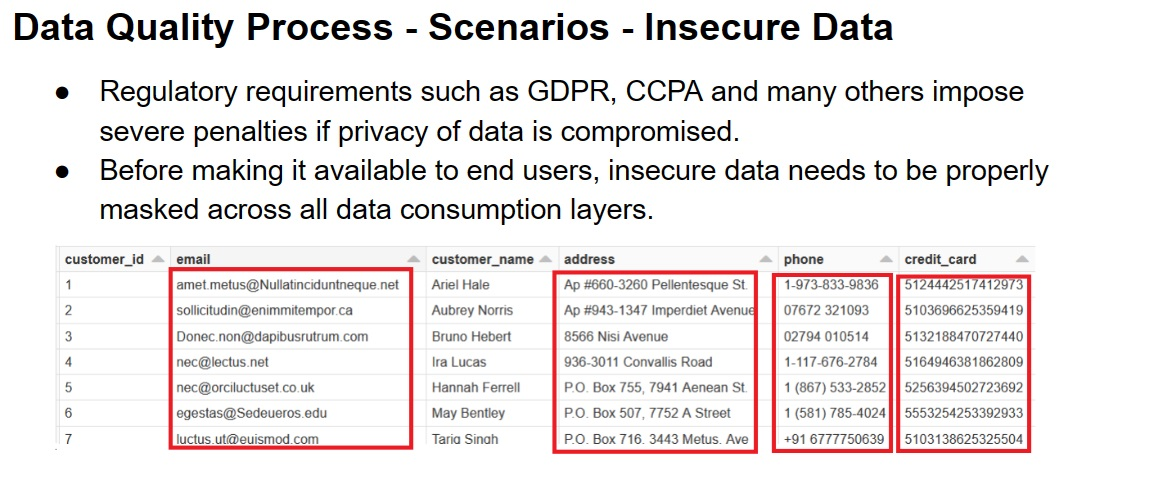

## Fetch customer data from bronze and apply data masking on PII columns

In [ ]:
cust_df = spark.sql("SELECT * FROM bronze_clean_store_customers")
curated_cust_df = cust_df.withColumn('email_curated',curate_email_udf('email')).drop('email').withColumnRenamed('email_curated', 'email')

curated_cust_df = curated_cust_df.withColumn('country_curated',curate_country_udf('country')).drop('country').withColumnRenamed('country_curated', 'country')
 
curated_cust_df = curated_cust_df.withColumn('phone_masked',mask_udf('phone')).drop('phone').withColumnRenamed('phone_masked', 'phone')
curated_cust_df = curated_cust_df.withColumn('credit_card_masked',mask_udf('credit_card')).drop('credit_card').withColumnRenamed('credit_card_masked', 'credit_card')
curated_cust_df = curated_cust_df.withColumn('credit_card_masked',mask_udf('credit_card')).drop('credit_card').withColumnRenamed('credit_card_masked', 'credit_card')
curated_cust_df = curated_cust_df.withColumn('address_masked',mask_udf('address')).drop('address').withColumnRenamed('address_masked', 'address')
curated_cust_df = curated_cust_df.withColumn('updated_at', f.lit(const_timestamp))
curated_cust_df.createOrReplaceTempView("store_customers")

### Now merge the results to the customer silver table

In [ ]:
%%sql
CREATE OR REPLACE TEMP VIEW store_customers_src AS 
SELECT DISTINCT * FROM store_customers;

MERGE INTO silver_store_customers c
USING store_customers_src u
ON c.customer_id = u.customer_id 
WHEN MATCHED THEN
  UPDATE SET c.customer_id = u.customer_id, 
             c.customer_name = u.customer_name,
             c.address = u.address,
             c.city = u.city,
             c.postalcode = u.postalcode,
             c.country = u.country,
             c.phone = u.phone,
             c.email = u.email,
             c.credit_card = u.credit_card,
             c.updated_at = u.updated_at
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_store_customers LIMIT 5;

# Implement Data Quality Rule 2 - Extract currency rates from JSON received from the REST API and convert all sales prices to USD and standardize date format
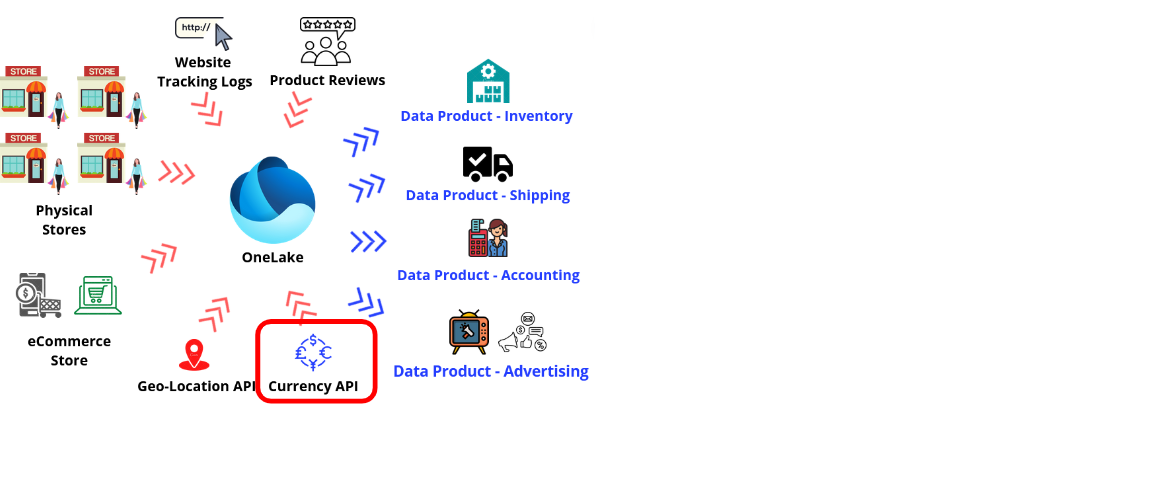
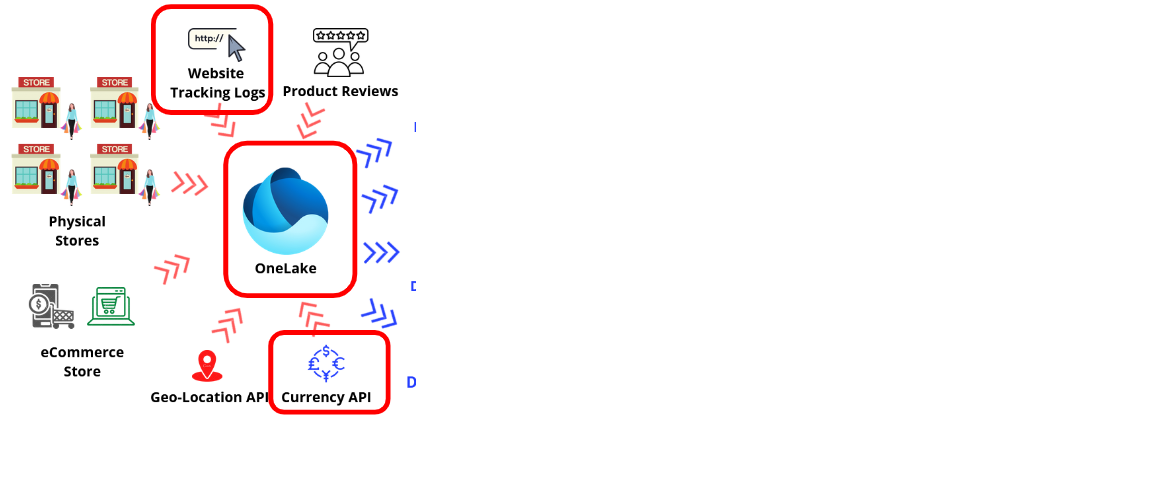

### Fetch data from REST API & create a Spark temporary table for the currency rates

In [ ]:
payload = json.loads(read_api(currency_api_url))
result = payload.get('_data')
rates = result.get('conversion_rates')
rates["USD"] = 1.00

ratesList = list(rates.items())
rates_df = spark.createDataFrame(ratesList,schema=currency_api_schema)
rates_df = rates_df.withColumn('updated_at', f.lit(const_timestamp))
rates_df.createOrReplaceTempView("currency_src")

### Now merge the results from the current API to the currency silver table

In [ ]:
%%sql

MERGE INTO silver_currency c
USING currency_src u
ON c.currency_name  = u.currency_name 
WHEN MATCHED THEN
  UPDATE SET c.currency_value = u.currency_value, 
             c.updated_at = u.updated_at
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_currency LIMIT 5;

### Apply the curate_sales_price_udf for conversion of base currency to USD. Also change the date format to a standard format of MM/dd/yyyy.

In [ ]:
order_df = spark.sql("SELECT * FROM bronze_valid_store_orders")
usd_df = spark.sql("""SELECT currency_name AS currency, currency_value 
                        FROM currency_src 
                       WHERE currency_name = 'USD'""")
     
curated_order_df = order_df.join(usd_df, on=['currency'], how="inner")
curated_order_df = curated_order_df.withColumn('sale_price_usd',curate_sales_price_udf('currency', 'currency_value', 'sale_price'))
curated_order_df = curated_order_df.withColumn('updated_at', f.lit(const_timestamp))
curated_order_df = curated_order_df.withColumn('order_date_new', f.to_date(curated_order_df.order_date, 'MM/dd/yyyy')).drop('order_date').withColumnRenamed('order_date_new', 'order_date')
curated_order_df = curated_order_df.drop('currency_value')
curated_order_df.createOrReplaceTempView("store_orders")

### Now merge the curated results to the store orders silver table

In [ ]:
%%sql
CREATE OR REPLACE TEMP VIEW store_orders_src AS 
SELECT DISTINCT * FROM store_orders;

MERGE INTO silver_store_orders c
USING store_orders_src u
ON c.order_number  = u.order_number  
WHEN MATCHED THEN
  UPDATE SET c.order_number = u.order_number, 
             c.customer_id = u.customer_id,
             c.product_id = u.product_id,
             c.order_date = u.order_date,
             c.units = u.units,
             c.sale_price = u.sale_price,
             c.sale_price_usd = u.sale_price_usd,
             c.currency = u.currency,
             c.order_mode = u.order_mode,
             c.updated_at = u.updated_at
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_store_orders LIMIT 5;



### Curate Products data

In [ ]:
products_df = spark.sql("SELECT * FROM bronze_products")
curated_products_df = products_df.withColumn('updated_at', f.lit(const_timestamp))
curated_products_df = curated_products_df.withColumnRenamed('product_code','product_id')
curated_products_df.createOrReplaceTempView("products")

### Now merge the curated results to the products silver table

In [ ]:
%%sql
CREATE OR REPLACE TEMP VIEW products_src AS 
SELECT DISTINCT * FROM products;

MERGE INTO silver_products c
USING products_src u
ON c.product_id  = u.product_id
WHEN MATCHED THEN
  UPDATE SET c.product_id = u.product_id, 
             c.product_name = u.product_name,
             c.product_category = u.product_category,
             c.updated_at = u.updated_at
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_products LIMIT 5;

# Implement Data Quality Rule 3 - Deal with non-uniform data related to country names in varying formats
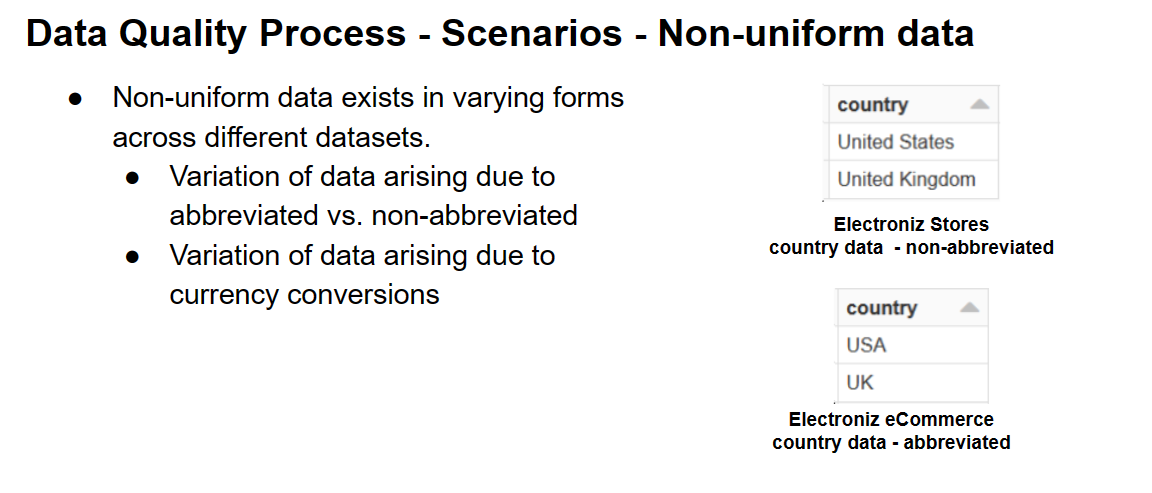

### Gather e-commerce sales data that is available in the Kusto Database.

In [ ]:
accessToken = mssparkutils.credentials.getToken(kusto_uri)
ecommerce_df  = spark.read\
            .format("com.microsoft.kusto.spark.synapse.datasource")\
            .option("accessToken", accessToken)\
            .option("kustoCluster", kusto_uri)\
            .option("kustoDatabase", kusto_database) \
            .option("kustoQuery", kusto_table).load()

display(ecommerce_df)

### Apply the curation UDF's for masking PII data, conversion of base currency to USD, date format to a standard format of MM/dd/yyyy.

In [ ]:
curated_ecom_df = ecommerce_df.withColumn('updated_at', f.lit(const_timestamp))
curated_ecom_df = curated_ecom_df.withColumn('phone_masked',mask_udf('phone')).drop('phone').withColumnRenamed('phone_masked', 'phone')
curated_ecom_df = curated_ecom_df.withColumn('address_masked',mask_udf('address')).drop('address').withColumnRenamed('address_masked', 'address')
curated_ecom_df = curated_ecom_df.withColumn('order_date', from_unixtime(unix_timestamp('order_date', 'dd/MM/yyy')))
curated_ecom_df = curated_ecom_df.withColumn('country_curated',curate_country_udf('country')).drop('country').withColumnRenamed('country_curated', 'country')
  
curated_ecom_df = curated_ecom_df.join(usd_df, on=['currency'], how="inner")
curated_ecom_df = curated_ecom_df.withColumn('sale_price_usd',curate_sales_price_udf('currency', 'currency_value', 'sale_price'))

curated_ecom_df = curated_ecom_df.withColumn('order_date_new', to_date(curated_ecom_df.order_date, 'yyyy-MM-dd HH:mm:ss')).drop('order_date').withColumnRenamed('order_date_new', 'order_date')

curated_ecom_df.createOrReplaceTempView("ecommerce_orders")

### Now merge the curated results to the ecommerce orders silver table

In [ ]:
%%sql
CREATE OR REPLACE TEMP VIEW ecommerce_orders_src AS 
SELECT DISTINCT * FROM ecommerce_orders;

MERGE INTO silver_ecommerce_orders c
USING ecommerce_orders_src u
ON c.email  = u.email
WHEN MATCHED THEN
  UPDATE SET c.customer_name = u.customer_name, 
             c.address = u.address,
             c.city = u.city,
             c.country = u.country,
             c.currency = u.currency,
             c.email = u.email,
             c.order_date = u.order_date,
             c.order_mode = u.order_mode,
             c.order_number = u.order_number,
             c.phone = u.phone,
             c.postalcode = u.postalcode,
             c.product_name = u.product_name,
             c.sale_price = u.sale_price,
             c.sale_price_usd = u.sale_price_usd,
             c.updated_at = u.updated_at
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_ecommerce_orders LIMIT 5;

# Implement Data Quality Rule 3 - Process website tracking locations to map IP addresses of visitors to the e-commerce to country of origin.
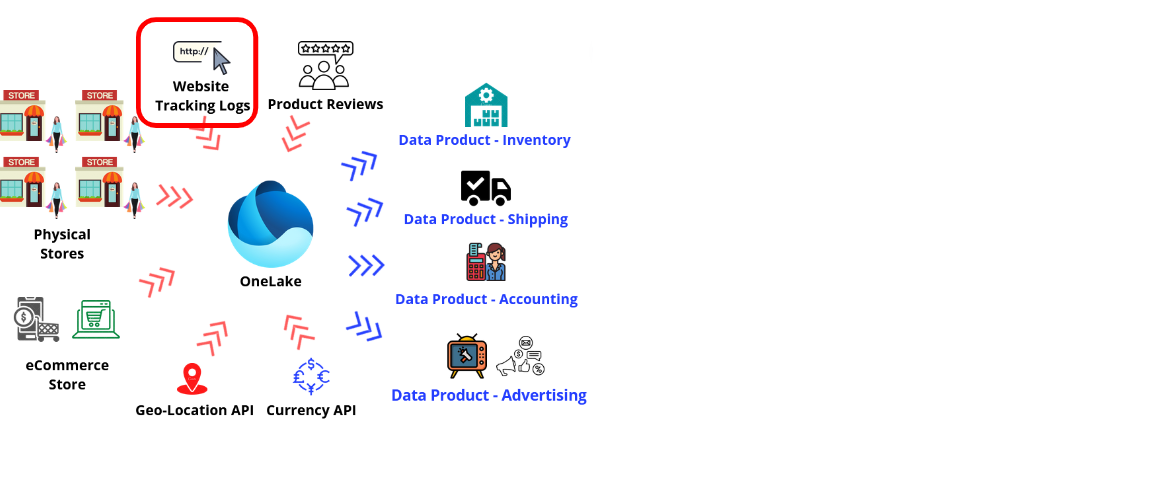

### Read the bronze geolocation data 

In [ ]:
geolocation_df = spark.sql("SELECT * FROM bronze_geolocation")
curated_geolocation_df = geolocation_df.withColumn('updated_at', f.lit(const_timestamp))
curated_geolocation_df.createOrReplaceTempView("geolocation")

### Now merge the curated results to the geolocation silver table

In [ ]:
%%sql
CREATE OR REPLACE TEMP VIEW geolocation_src AS 
SELECT DISTINCT * FROM geolocation;

MERGE INTO silver_geolocation c
USING geolocation_src u
ON c.ip1  = u.ip1
WHEN MATCHED THEN
  UPDATE SET c.ip1 = u.ip1, 
             c.ip2 = u.ip2,
             c.country_code = u.country_code,
             c.country_name = u.country_name,
             c.updated_at = u.updated_at
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_geolocation LIMIT 5;
     

### Use the Pandas library to read website logs

In [ ]:
pd_dfs = [] 

for file in log_file_list:
    data = pd.read_json(file, lines=True) 
    pd_dfs.append(data) 

pd_df = pd.concat(pd_dfs, ignore_index=True)

### Convert the pandas dataframe to a spark dataframe. Apply ip_to_country_udf UDF to map IP address to country.

In [ ]:
logs_df = spark.createDataFrame(pd_df)
curated_logs_df = logs_df.withColumn('updated_at', f.lit(const_timestamp))
curated_logs_df = curated_logs_df.withColumn('time', from_unixtime(unix_timestamp('time', 'dd/MM/yyy:HH:m:ss')))
curated_logs_df = curated_logs_df.withColumn('ip_number',ip_to_country_udf('remote_ip'))
curated_logs_df = curated_logs_df.withColumn("ip_number_int", curated_logs_df['ip_number'].cast('int')).drop('ip_number').withColumnRenamed('ip_number_int', 'ip_number')
curated_logs_df.createOrReplaceTempView('logs')

### Now merge the curated results to the website logs silver table

In [ ]:
%%sql
CREATE OR REPLACE TEMP VIEW logs_src AS 
SELECT DISTINCT * FROM
(SELECT logs.time
	,logs.remote_ip
	,geolocation_src.country_name
	,logs.ip_number
	,logs.request
	,logs.response
	,logs.agent
	,logs.updated_at
FROM logs
JOIN geolocation_src
WHERE ip1 <= ip_number
	AND ip2 >= ip_number);

MERGE INTO silver_logs c
USING logs_src u
ON c.remote_ip   = u.remote_ip 
WHEN NOT MATCHED THEN 
  INSERT *;

SELECT * FROM silver_logs LIMIT 5;

# Implement Data Quality Rule 4 - Process the inventory table

In [ ]:
inventory_df = spark.sql("SELECT * FROM bronze_inventory")
inventory_df.createOrReplaceTempView("inventory")

In [ ]:
%%sql
MERGE INTO silver_inventory si
USING inventory i
ON si.product   = i.product 
WHEN NOT MATCHED THEN 
  INSERT *;
